<a href="https://colab.research.google.com/github/dauhoangganh/ADXL382_Pico_Streamlit_Example/blob/main/stepping_motor_fault_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 24 06:52:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# **Dataset acquisition**

In [ ]:
# prompt: unzip dateset.zip in content folder

!unzip dataset.zip -d /content/
%cd /content/dataset
%ls /content/dataset

Archive:  dataset.zip
   creating: /content/dataset/
   creating: /content/dataset/Fast_rate/
  inflating: /content/dataset/Fast_rate/data (1).csv  
  inflating: /content/dataset/Fast_rate/data (10).csv  
  inflating: /content/dataset/Fast_rate/data (11).csv  
  inflating: /content/dataset/Fast_rate/data (12).csv  
  inflating: /content/dataset/Fast_rate/data (13).csv  
  inflating: /content/dataset/Fast_rate/data (14).csv  
  inflating: /content/dataset/Fast_rate/data (15).csv  
  inflating: /content/dataset/Fast_rate/data (16).csv  
  inflating: /content/dataset/Fast_rate/data (17).csv  
  inflating: /content/dataset/Fast_rate/data (18).csv  
  inflating: /content/dataset/Fast_rate/data (19).csv  
  inflating: /content/dataset/Fast_rate/data (2).csv  
  inflating: /content/dataset/Fast_rate/data (20).csv  
  inflating: /content/dataset/Fast_rate/data (21).csv  
  inflating: /content/dataset/Fast_rate/data (22).csv  
  inflating: /content/dataset/Fast_rate/data (23).csv  
  inflating:

In [ ]:
"""
Any config specific to data acquisition step goes here.
"""

from pathlib import Path
import glob
from collections import namedtuple

# Select input data directory
INPUT_DATA_DIR = Path('/content/dataset/')
# Input data paths
NORMAL_FILE_NAMES = glob.glob(str(INPUT_DATA_DIR)+'/Normal/*.csv')
SLOW_RATE_FILE_NAMES = glob.glob(str(INPUT_DATA_DIR)+'/Slow_rate/*.csv')
FAST_RATE_FILE_NAMES = glob.glob(str(INPUT_DATA_DIR)+'/Fast_rate/*.csv')
STOP_FILE_NAMES = glob.glob(str(INPUT_DATA_DIR)+'/Stop/*.csv')


# Output data path
OUTPUT_DATA_DIR = Path('/content/drive/MyDrive/checkpoints')
OUTPUT_DATA_FILE = OUTPUT_DATA_DIR / Path('raw_data.p')

#Define dataset tuple
Dataset = namedtuple(
    'Dataset',
    'normal slow_rate fast_rate stop'
    )

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import logging
import pickle

logging.basicConfig(level=print)


def _dataReader(path_names: list) -> list:
    '''
    Reads in raw data from .csv files and returns a list

    params:
    ---
    path_names (list): list of all the data files to read in

    returns:
    ---
    sequences (list): raw dataset from data directory
    '''

    sequences = list()

    for name in path_names:
        data = pd.read_csv(name, header=0)
        sequences.append(data.values)

    return sequences #shape (n_samples, n_time_points, n_channels)


def get_save_data() -> Dataset:
    '''
    runs the `_dataReader` method and
    stores the raw data into a Dataset named tuple.

    returns:
    ---
    dataset (Dataset): named tuple of (data_n)
    '''
    if Path.exists(OUTPUT_DATA_FILE):
        print('Loading previously pickled `raw_data`')
        dataset = pickle.load(open(OUTPUT_DATA_FILE, 'rb'))
    else:
        OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)

        print("Loading raw data.")

        data_normal = np.stack(_dataReader(NORMAL_FILE_NAMES)) #shape (n_samples, n_time_points, n_channels)
        data_slow_rate = np.stack(_dataReader(SLOW_RATE_FILE_NAMES))
        data_fast_rate = np.stack(_dataReader(FAST_RATE_FILE_NAMES))
        data_stop = np.stack(_dataReader(STOP_FILE_NAMES))

        print("Load complete.")

        dataset = Dataset(
            data_normal,
            data_slow_rate,
            data_fast_rate,
            data_stop
            )
        pickle.dump(dataset, open(OUTPUT_DATA_FILE, 'wb'))

    return dataset

In [ ]:
dataset = get_save_data()
print(len(dataset.normal))
print(len(dataset.slow_rate))
print(len(dataset.fast_rate))
print(len(dataset.stop))

Loading raw data.
Load complete.
52
55
52
51


# **Data processing**

In [ ]:
"""
Any config specific to data processing step goes here.
"""

DATA_TEST_SIZE = 0.2  # Test sample size
SAMPLE_RATE = 16000  # Data acquisition system processing frequency
RESAMPLE_RATE = 1  # Resample rate used to desample the time-series
DURATION = 4  # Time-series duration in seconds

# Output data path
OUTPUT_TRAIN_TEST_DATA_DIR = Path('/content/drive/MyDrive/checkpoints')
OUTPUT_TRAIN_TEST_DATA_FILE = OUTPUT_DATA_DIR / Path('train_test_data.p')
# Graph Output data path
GRAPH_OUTPUT_DATA_DIR = Path('/content/drive/MyDrive/output/plots')

ProcessedDataset = namedtuple('ProcessedDataset', 'X_train X_test y_train y_test')

In [ ]:
"""
Any utility function that is required for data processing goes here
"""

from pathlib import Path
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.fft import rfft
import logging
import pickle

logging.basicConfig(level=print)


def _dataScaler(data: list) -> list:
    '''
    Reads in data and returns a scaled list.

    params:
    ---
    data (list): a list of data to scale--->(3D array (samples, time steps, features))

    returns:
    ---
    final_sequence (list): resampled data
    '''
    data_temp = np.reshape(data, (-1, data.shape[2])) #reshapes 3D array into a 2D array where all the time steps from all samples are stacked together.
    norm = MinMaxScaler().fit(data_temp)
    data_norm = norm.transform(data_temp)
    data_final = np.reshape(data_norm, (-1, data.shape[1], data.shape[2])) #transform 2D array back into 3D

    return data_final


def _downSampler(data: list, start_index: int, sample_rate: int) -> list:
    '''
    Reads in raw data from .csv files and returns a resampled list

    params:
    ---
    data (list): a list of data to down sample --->(3D array (samples, time steps, features))
    start_index (int): starting index
    sample_rate (int): sampling rate

    returns:
    ---
    final_sequence (list): resampled data
    '''
    final_sequence = list()
    for dataset in data:
        data_resampled = []
        start = start_index
        stop = sample_rate
        for i in range(int(len(dataset)/sample_rate)):
            data_resampled.append(dataset[start:stop, :].mean(axis=0))
            start += sample_rate
            stop += sample_rate
        final_sequence.append(np.stack(data_resampled))

    return np.stack(final_sequence)


def _FFT(data: list) -> list:
    '''
    Reads in resampled data and performs a Fast Fourier Transform with DC offset removal

    params:
    ---
    data (pd.DataFrame): a list of data to perform Fast Fourier Transform --->(3D array (samples, time steps, features))
    returns:
    ---
    data_fft (list): FFT data
    '''
    data_fft = list()
    for dataset in data:
      #rfft(dataset, axis=0): This is the core of the FFT operation. rfft stands for "real FFT," which is an optimized version of the FFT for real-valued input data (like the time-series data in this case).
      #It computes the one-dimensional discrete Fourier Transform along the specified axis (axis=0, which is the time step axis). The output of rfft is complex-valued and contains the frequency components of the signal.
      #np.abs(...): This takes the absolute value of the complex output from rfft. The absolute value of a complex number gives its magnitude, which represents the strength or amplitude of the corresponding frequency component in the signal.
      # [1:, :]: This is array slicing. In the context of the FFT output, the first element (index 0) typically represents the DC component (the average value or zero frequency component) of the signal. This slicing effectively removes the DC component from the FFT result.
        data_fft.append(np.stack(np.abs(rfft(dataset, axis=0))[1:, :]))

    return np.stack(data_fft)


def get_save_train_test_data(raw_data: Dataset) -> ProcessedDataset:
    '''
    runs the 'get_data()' and '_downSampler' methods
    to generate training and testing data sets

    params:
    ---
    dataset (Dataset): raw data set from data_acquisition module

    returns:
    ---
    train_test_data (Dataset): named tuple of (X_train, y_train, X_test, y_test)
    '''
    if Path.exists(OUTPUT_TRAIN_TEST_DATA_FILE):
        print('Loading previously pickled `train_test_data`')
        train_test_data = pickle.load(open(OUTPUT_TRAIN_TEST_DATA_FILE, 'rb'))
    else:
        OUTPUT_TRAIN_TEST_DATA_DIR.mkdir(parents=True, exist_ok=True)

        print(f"Data is being resampled at a sample rate of: {RESAMPLE_RATE}")
        data_normal = _downSampler(raw_data.normal, 0, RESAMPLE_RATE)
        data_slow_rate = _downSampler(raw_data.slow_rate, 0, RESAMPLE_RATE)
        data_fast_rate = _downSampler(raw_data.fast_rate, 0, RESAMPLE_RATE)
        data_stop = _downSampler(raw_data.stop, 0, RESAMPLE_RATE)


        print("Scaling the data.")
        data_normal = _dataScaler(data_normal)
        data_slow_rate = _dataScaler(data_slow_rate)
        data_fast_rate = _dataScaler(data_fast_rate)
        data_stop = _dataScaler(data_stop)

        print("Performing FFT.")
        data_normal = _FFT(data_normal)
        data_slow_rate = _FFT(data_slow_rate)
        data_fast_rate = _FFT(data_fast_rate)
        data_stop = _FFT(data_stop)

        print("Creating labels.")
        y_1 = np.zeros(int(len(data_normal)), dtype=int)
        y_2 = np.full(int(len(data_slow_rate)), 1)
        y_3 = np.full(int(len(data_fast_rate)), 2)
        y_4 = np.full(int(len(data_stop)), 3)

        y = np.concatenate((y_1, y_2, y_3, y_4))

        X = np.concatenate((data_normal, data_slow_rate, data_fast_rate, data_stop))

        print(f"Spliting data to a test size of: {DATA_TEST_SIZE}")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=DATA_TEST_SIZE, random_state=42) #shuffle and split data for training and testing

        train_test_data = ProcessedDataset(X_train, X_test, y_train, y_test)
        pickle.dump(train_test_data, open(OUTPUT_TRAIN_TEST_DATA_FILE, 'wb'))

        print("Complete.")

    return train_test_data

In [ ]:
"""
Any utility function that is required for data exploratory analysis goes here
"""

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfftfreq

def time_plot(yf_list, start: int, stop: int, fname: str, legend: list):
    '''
    Plots a time series

    params:
    ---
    yf_list (list of np.ndarray): input data to plot
    start (int): start time (s)
    stop (int): stop time (s)
    fname (str): save file name
    legend (list): legend names
    '''
    time = np.linspace(0, DURATION, len(yf_list[0]), endpoint=False)

    _, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)
    for yf in yf_list:
      plt.plot(time[start:stop], yf[start:stop], label=legend.pop(0))

    axs.set_title('Time-series signal')
    axs.set_ylabel('Acceleration (g)', fontsize=14)
    axs.set_xlabel('Time (s)', fontsize=14)
    axs.legend()
    GRAPH_OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
    file_location = GRAPH_OUTPUT_DATA_DIR / Path(f'{fname}.png')
    plt.savefig(file_location)


def fft_plot(yf_list, fname: str, legend: list):
    '''
    Plots the FFT

    params:
    ---
    yf_list (list of np.ndarray): input data to plot
    fname (str): save file name
    '''
    N = int((SAMPLE_RATE / RESAMPLE_RATE) * DURATION) #N=16000/1*2 = 32000
    xf = rfftfreq(N-1, 1 / int(SAMPLE_RATE / RESAMPLE_RATE)) #resulting spectrum has N//2 + 1 frequency bins

    _, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)

    for i, yf in enumerate(yf_list):
        plt.plot(xf, yf, label=legend[i])
    axs.set_title('Frequency spectra')
    axs.set_ylabel('Signal strength', fontsize=14)
    axs.set_xlabel('Frequency (Hz)', fontsize=14)
    axs.legend()
    GRAPH_OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
    file_location = GRAPH_OUTPUT_DATA_DIR / Path(f'{fname}.png')
    plt.savefig(file_location)

In [ ]:
# Data Plotting
data_normal = dataset.normal.copy()
data_fast_rate = dataset.fast_rate.copy()
data_slow_rate = dataset.slow_rate.copy()
print(len(data_normal))
print(len(data_normal[0]))
data_normal

52
64000


array([[[ 1.1995,  0.135 , -0.1055],
        [ 1.1665,  0.1635, -0.0655],
        [ 1.1275,  0.2985, -0.024 ],
        ...,
        [ 0.969 ,  0.2315,  0.0665],
        [ 1.0055,  0.1995,  0.068 ],
        [ 1.0175,  0.2465,  0.084 ]],

       [[ 1.071 ,  0.1715,  0.042 ],
        [ 1.0895,  0.3255,  0.02  ],
        [ 1.117 ,  0.4405,  0.005 ],
        ...,
        [ 1.0985,  0.38  ,  0.002 ],
        [ 1.0805,  0.333 , -0.0505],
        [ 1.0515,  0.221 , -0.0435]],

       [[ 1.0065,  0.2465,  0.0635],
        [ 1.03  ,  0.328 ,  0.0715],
        [ 1.067 ,  0.3155,  0.0625],
        ...,
        [ 1.143 ,  0.2295, -0.05  ],
        [ 1.113 ,  0.2955, -0.022 ],
        [ 1.0725,  0.3325, -0.025 ]],

       ...,

       [[ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.006 ,  0.0015],
        ...,
        [ 1.2095,  0.1885, -0.1175],
        [ 1.168 ,  0.1705, -0.0635],
        [ 1.1365,  0.2505, -0.0695]],

       [[ 0.9935,  0.1625, -0.002 ],
  

In [ ]:
data_normal[0][:, [0]]

array([[1.1995],
       [1.1665],
       [1.1275],
       ...,
       [0.969 ],
       [1.0055],
       [1.0175]])

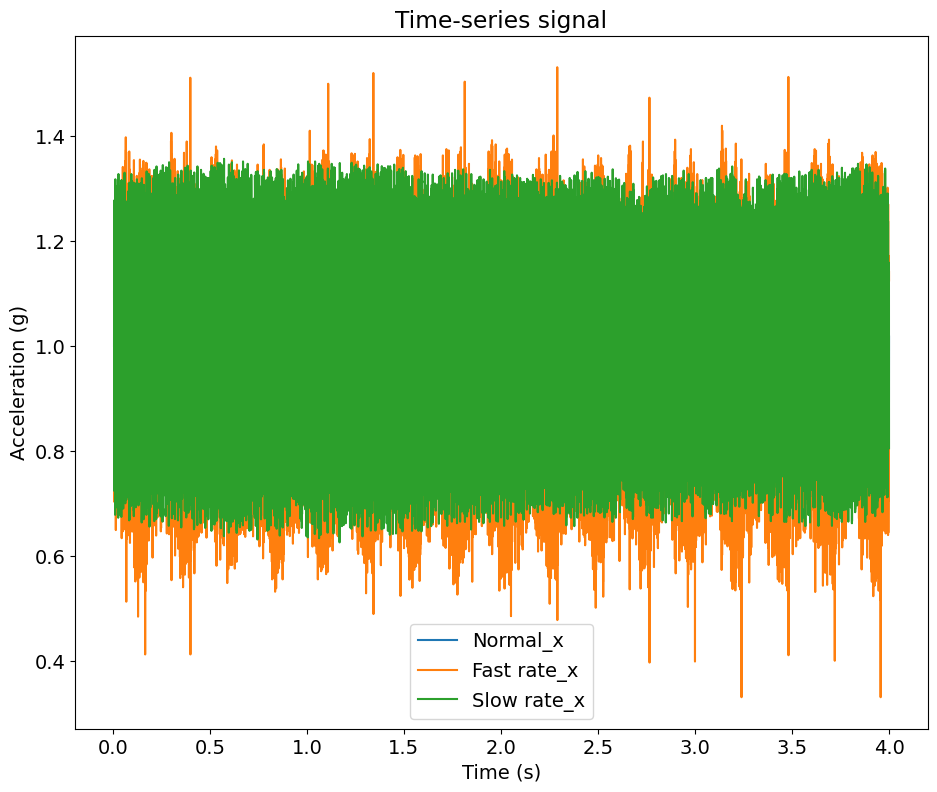

In [ ]:
time_plot([data_normal[0][:, [0]], data_fast_rate[0][:, [0]], data_slow_rate[0][:, [0]]], 100, SAMPLE_RATE*DURATION, 'time_plot', legend=["Normal_x", "Fast rate_x", "Slow rate_x"])

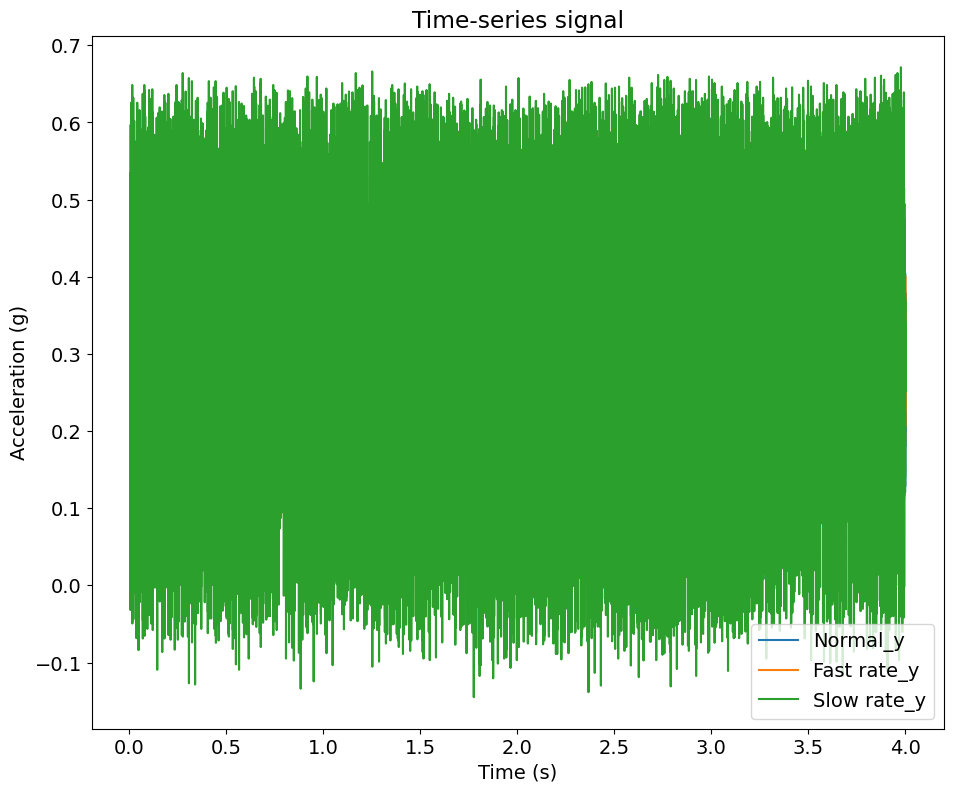

In [ ]:
time_plot([data_normal[0][:, [1]], data_fast_rate[0][:, [1]], data_slow_rate[0][:, [1]]], 100, SAMPLE_RATE*DURATION, 'time_plot', legend=["Normal_y", "Fast rate_y", "Slow rate_y"])

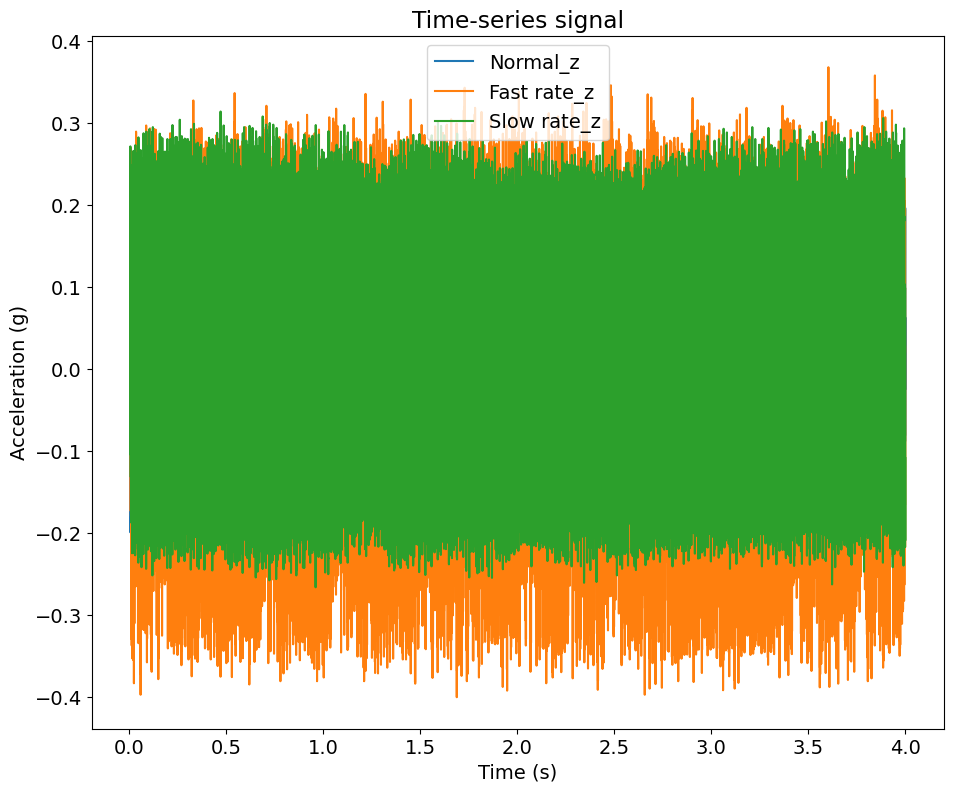

In [ ]:
time_plot([data_normal[0][:, [2]], data_fast_rate[0][:, [2]], data_slow_rate[0][:, [2]]], 100, SAMPLE_RATE*DURATION, 'time_plot', legend=["Normal_z", "Fast rate_z", "Slow rate_z"])

In [ ]:
# Data Resampling
data_n_resampled = _downSampler(data_normal, 0, RESAMPLE_RATE)
data_n_resampled_fft = _FFT(data_n_resampled)
data_n_resampled_fft.shape

(52, 32000, 3)

In [ ]:
data_fast_rate_resampled = _downSampler(data_fast_rate, 0, RESAMPLE_RATE)
data_fast_rate_resampled_fft = _FFT(data_fast_rate_resampled)
data_slow_rate_resampled = _downSampler(data_slow_rate, 0, RESAMPLE_RATE)
data_slow_rate_resampled_fft = _FFT(data_slow_rate_resampled)

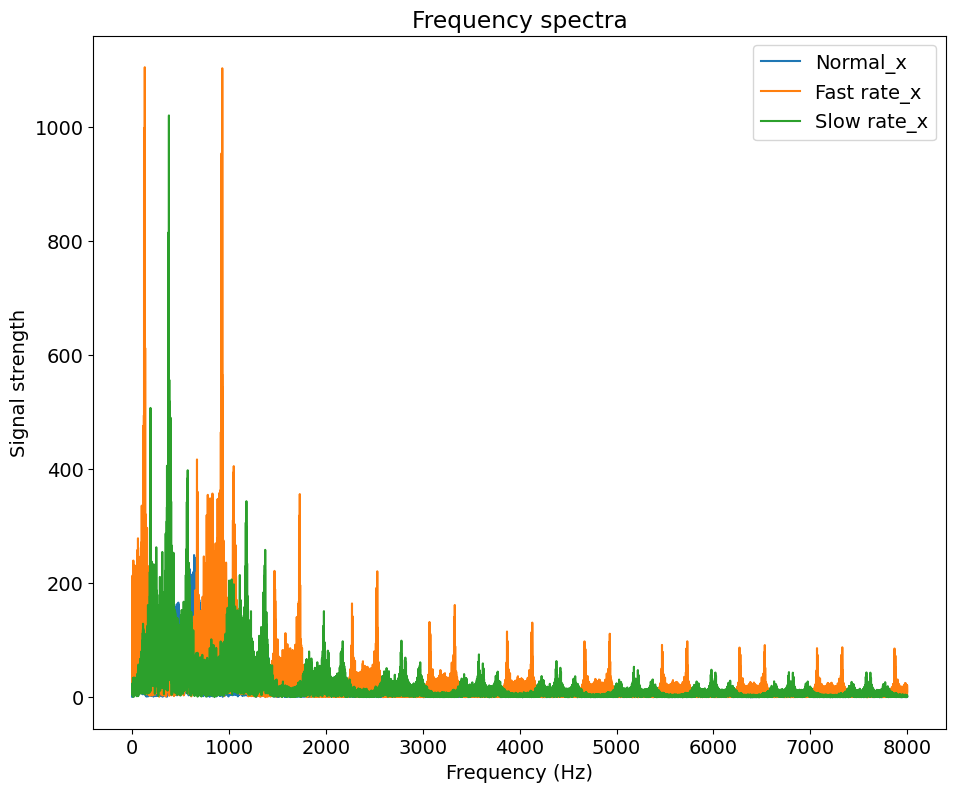

In [ ]:
fft_plot([data_n_resampled_fft[0][:, [0]], data_fast_rate_resampled_fft[0][:, [0]], data_slow_rate_resampled_fft[0][:, [0]]], 'fft_normal_resampled', legend=["Normal_x", "Fast rate_x", "Slow rate_x"])

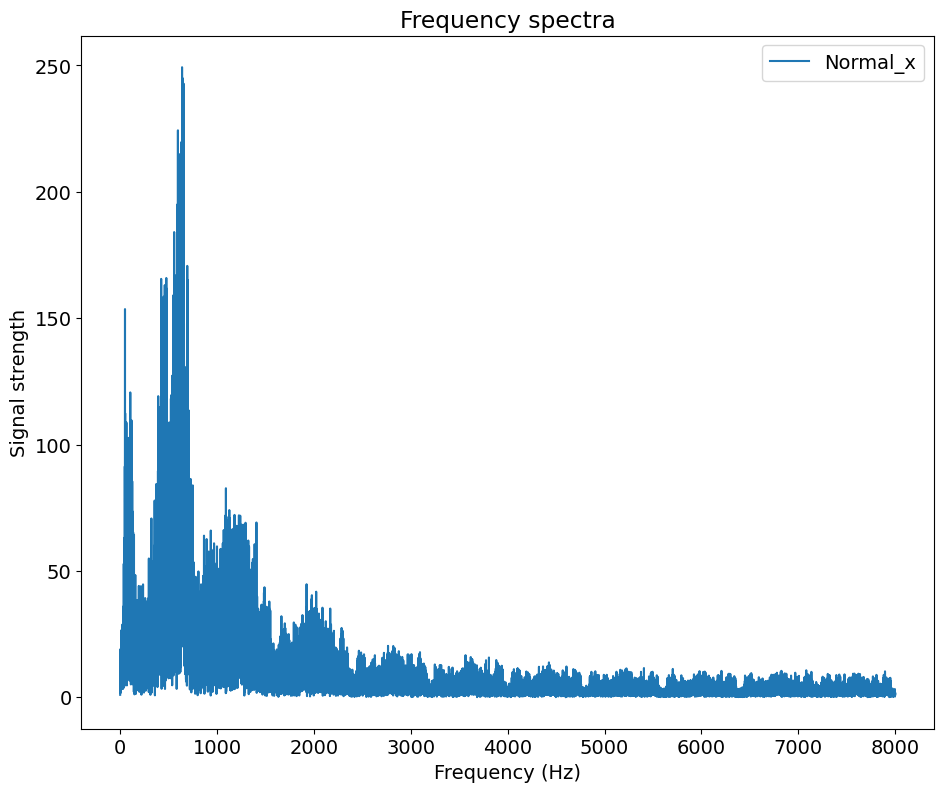

In [ ]:
fft_plot([data_n_resampled_fft[0][:, [0]]], 'fft_normal_resampled', legend=["Normal_x"])

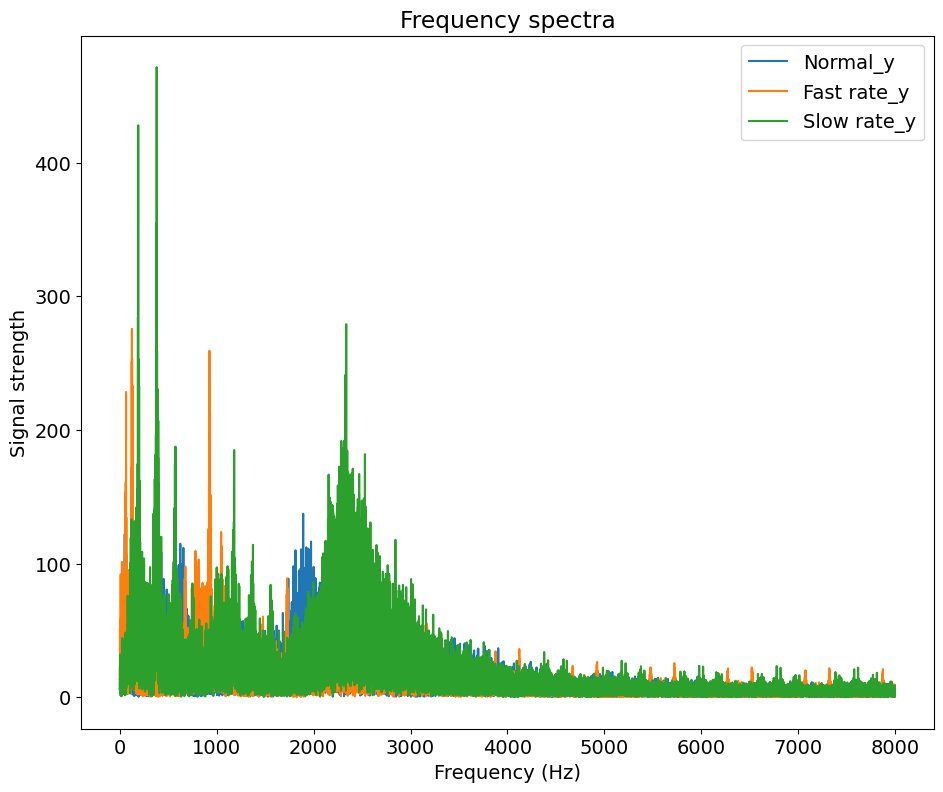

In [ ]:
fft_plot([data_n_resampled_fft[0][:, [1]], data_fast_rate_resampled_fft[0][:, [1]], data_slow_rate_resampled_fft[0][:, [1]]], 'fft_normal_resampled', legend=["Normal_y", "Fast rate_y", "Slow rate_y"])

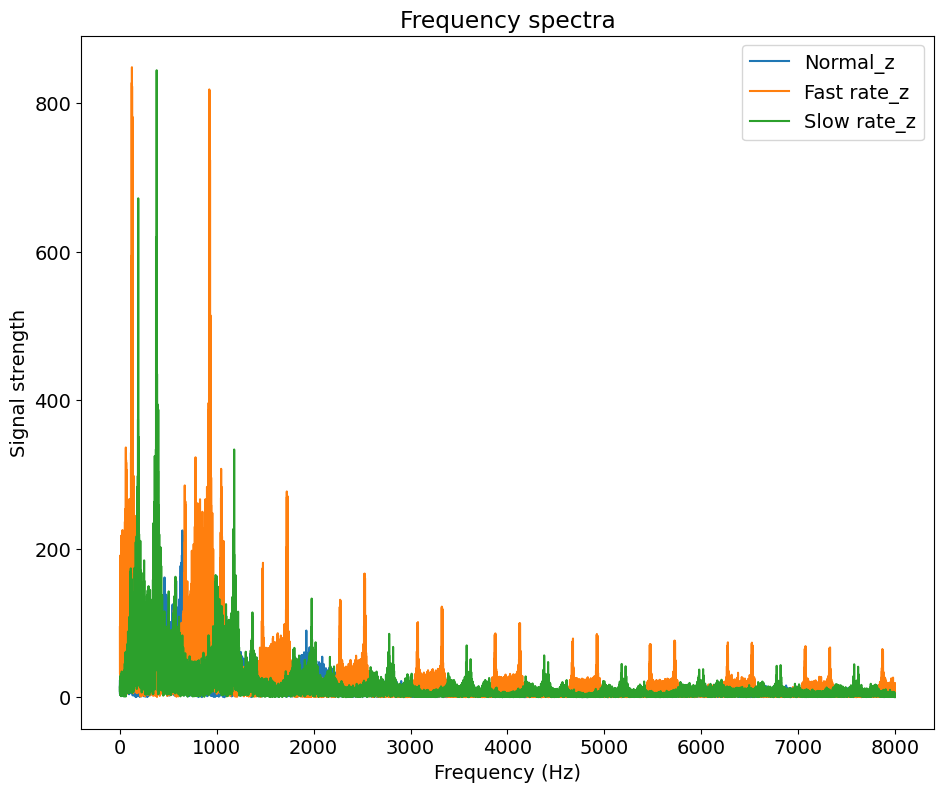

In [ ]:
fft_plot([data_n_resampled_fft[0][:, [2]], data_fast_rate_resampled_fft[0][:, [2]], data_slow_rate_resampled_fft[0][:, [2]]], 'fft_normal_resampled', legend=["Normal_z", "Fast rate_z", "Slow rate_z"])

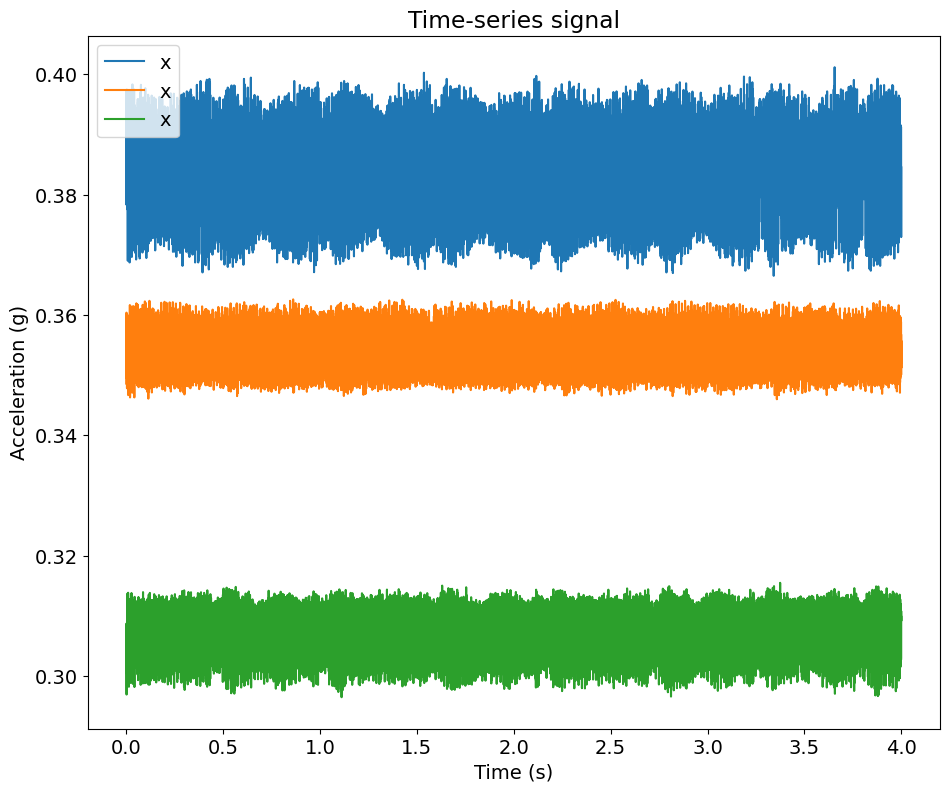

In [ ]:
# Data Scaling
data_n_resampled_scaled = _dataScaler(data_n_resampled)
time_plot([data_n_resampled_scaled[0]], 0, SAMPLE_RATE*DURATION, 'data_scaled', legend=["x", "y", "z"])


# **Model training**

In [ ]:
"""
Any config specific to model training step goes here.
"""

from pathlib import Path

# General configuration
MONITOR = 'val_loss'
VAL_SPLIT = 0.2
# LSTM_UNITS = 200
OPTIMIZER = 'adam'
EPOCHS = 300

# Multi-class classification
OUTPUT_SIZE = 4 #4 labels for classification
ACTIVATION = 'softmax'
LOSS_FUNCTION = 'sparse_categorical_crossentropy'

# Output data path
OUTPUT_MODEL_DIR = Path('/content/drive/MyDrive/output')

In [ ]:
from re import X
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
logging.basicConfig(level=print)

OUTPUT_MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Model Development
# Load the data
# dataset = get_save_data()

# Process the data and train/test split
train_test_data = get_save_train_test_data(dataset)

# Prepare the data
X_train = np.array(train_test_data.X_train)
X_test = np.array(train_test_data.X_test)

y_train = np.array(train_test_data.y_train)
y_test = np.array(train_test_data.y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Loading previously pickled `train_test_data`


((168, 32000, 3), (42, 32000, 3), (168,), (42,))

In [ ]:
# Generating the model
model = Sequential()
model.add(Conv1D(64, kernel_size=64, activation='relu', input_shape=[X_train.shape[1], X_train.shape[2]]))
# model.add(Dense(OUTPUT_SIZE, activation=ACTIVATION))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=32))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=64, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=32))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=OUTPUT_SIZE, activation='softmax'))


print(model.summary())
model_path = OUTPUT_MODEL_DIR / Path('best_model.keras')
chk = ModelCheckpoint(model_path, monitor=MONITOR, save_best_only=True, mode='auto', verbose=1)
early_stopping_cb = EarlyStopping(monitor=MONITOR, patience=10, restore_best_weights=True)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 31937, 64)      │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 31937, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 998, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 998, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 935, 128)       │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 935, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3712)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       475,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,316 (3.87 MB)

 Trainable params: 1,012,932 (3.86 MB)

 Non-trainable params: 384 (1.50 KB)

None


# **Model training**

In [ ]:
# Training the model

hist = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=16,
    callbacks=[chk, early_stopping_cb],
    validation_split=VAL_SPLIT
    )



Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.5505 - loss: 1.9163
Epoch 1: val_loss improved from inf to 21.45998, saving model to /content/drive/MyDrive/output/best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 746ms/step - accuracy: 0.5656 - loss: 1.8475 - val_accuracy: 0.4706 - val_loss: 21.4600
Epoch 2/300
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8786 - loss: 0.4654
Epoch 2: val_loss improved from 21.45998 to 3.15537, saving model to /content/drive/MyDrive/output/best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8923 - loss: 0.4040 - val_accuracy: 0.6176 - val_loss: 3.1554
Epoch 3/300
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9695 - loss: 0.2552
Epoch 3: val_loss improved from 3.15537 to 0.00867, saving model to /content/drive/MyDrive/output/best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9695 - loss: 0.2472 - val_accuracy: 1.0000 - val_loss: 0.0087
Epoch 4/300
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accurac

# **Model validation**

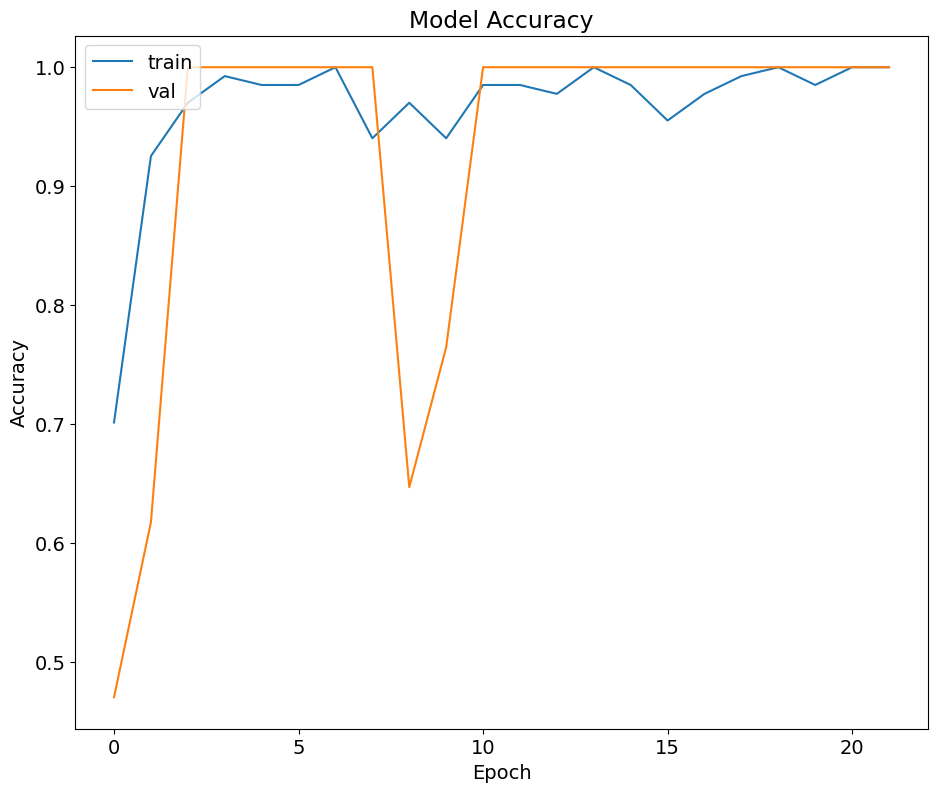

In [ ]:
# Model Validation
# Plotting training and validation accuracy per epoch
_, axs = plt.subplots(nrows=1, figsize=(11, 9))
file_location = OUTPUT_MODEL_DIR / Path('plots/model_accuracy.png')
plt.rcParams['font.size'] = '14'

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(14)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

axs.set_title('Model Accuracy')
axs.set_ylabel('Accuracy', fontsize=14)
axs.set_xlabel('Epoch', fontsize=14)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(file_location)

# **Model evaluation**

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
# Prepare the data
# X_test = np.array(train_test_data.X_test)
# y_test = np.array(train_test_data.y_test)

# Loading the model and checking accuracy on the test data
model_path = OUTPUT_MODEL_DIR / Path('best_model.keras')
model = load_model(model_path)

#model.predict(X_test) produces the predicted probabilities for each class for every sample in X_test.
#Output shape: (num_samples, num_classes) (e.g., (100, 4) for 4 classes).
#np.argmax(..., axis=-1) picks the index (class) with the highest predicted probability for each sample.
test_preds = np.argmax(model.predict(X_test), axis=-1)
print(accuracy_score(y_test, test_preds))

# # Comparing the actual values versus the predicted values
# data_dict = {
#     0: 'normal',
#     1: 'slow rate',
#     2: 'fast rate',
#     3: 'stop',
#     }
# results = pd.DataFrame([y_test, test_preds]).T
# results.columns = ['Actual', 'Prediction']
# results['Actual'] = results['Actual'].map(data_dict)
# results['Prediction'] = results['Prediction'].map(data_dict)

# print(results)

NameError: name 'OUTPUT_MODEL_DIR' is not defined

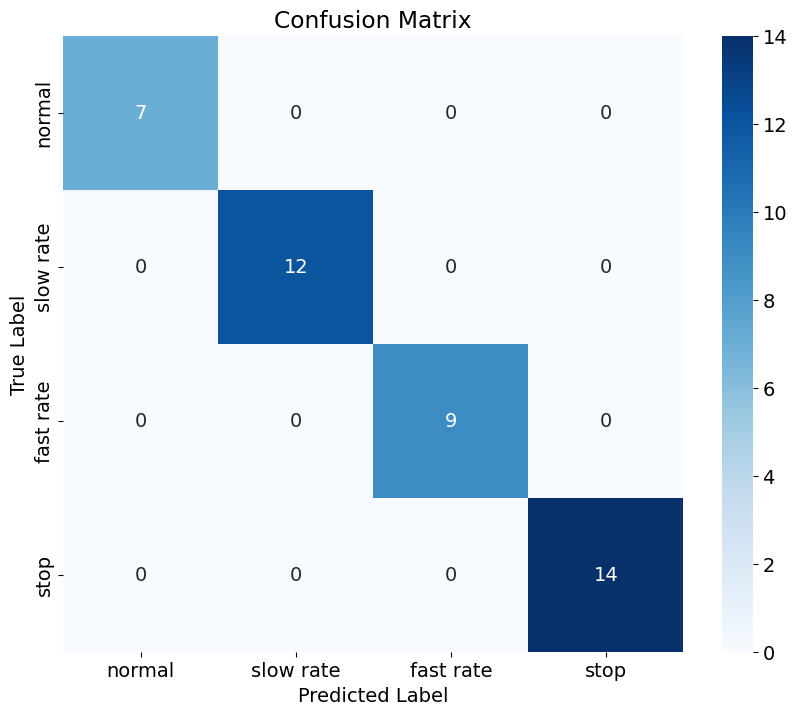

In [ ]:
# prompt: create confusion matrix for my evaluation result

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=data_dict.values(), yticklabels=data_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
